# Business Understanding

Text

In [2]:
reset -fs

In [3]:
# Importing the most important modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time
from tqdm import tqdm
import random

# Import plotly modules to view time series in a more interactive way
import plotly.graph_objects as go
import plotly.offline as pyo
from matplotlib.pyplot import cm
from IPython.display import Image

# Importing time series split for cross validation of time series models
from sklearn.model_selection import TimeSeriesSplit

# For Data Mining
import os, glob

# For Data Cleaning
from datetime import datetime
import missingno as msno

from pandas import read_csv
from pandas import datetime

from matplotlib import pyplot
import matplotlib.dates as mdates
from matplotlib.dates import date2num

# Importing metrics to evaluate the implemented models
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Importing Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller

# Importing autocorrelation function and partial autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importing ARIMA Model
from statsmodels.tsa.arima_model import ARIMA

# Automated search for optimal ARIMA order
import pmdarima as pm

## Global Variables and Settings

In [4]:
# Setting the random seed for reproducability and several plotting style parameters
%matplotlib inline
plt.style.use('seaborn')
pyo.init_notebook_mode()
sns.set(rc={'figure.figsize':(14,8)})
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
RSEED = 42

# Load Data

In [5]:
#data has been saved using a .pkl file. 
path = './data/df_small.pkl'
df = pd.read_pickle(path)
df.head(2)

target_losses_norm  dswrf_sfc_wm2  gust_sfc_ms  \
2018-01-01 06:00:00            0.425598            0.0    16.777032   
2018-01-01 06:10:00            0.404513            0.0    16.748651   

                      hpbl_sfc_m     msl_ms_pa  r_pl925_perc  shtfl_sfc_wm2  \
2018-01-01 06:00:00  1349.927656  99212.062500     89.975000     -58.444885   
2018-01-01 06:10:00  1350.376965  99220.020833     89.854167     -58.558706   

                       t_100m_k      t_2m_k  tcclow_sfc_perc  wdir_100m_dn  \
2018-01-01 06:00:00  280.079346  280.496348        99.375000     54.455224   
2018-01-01 06:10:00  280.057788  280.470277        99.354167     55.784078   

                     wdir_10m_dn  wsp_100m_ms  wsp_10m_ms  working_day  \
2018-01-01 06:00:00    51.936818    16.548291    9.772748        False   
2018-01-01 06:10:00    53.253883    16.589409    9.804977        False   

                     weekday//Monday  weekday//Saturday  weekday//Sunday  \
2018-01-01 06:00:00                1                  0                0   
2018-01-01 06:10:00                1                  0                0   

                     weekday//Thursday  weekday//Tuesday  weekday//Wednesday  \
2018-01-01 06:00:00                  0                 0                   0   
2018-01-01 06:10:00                  0                 0                   0   

                     hour//1  hour//2  hour//3  hour//4  hour//5  hour//6  \
2018-01-01 06:00:00        0        0        0        0        0        1   
2018-01-01 06:10:00        0        0        0        0        0        1   

                     hour//7  hour//8  hour//9  hour//10  hour//11  hour//12  \
2018-01-01 06:00:00        0        0        0         0         0         0   
2018-01-01 06:10:00        0        0        0         0         0         0   

                     hour//13  hour//14  hour//15  hour//16  hour//17  \
2018-01-01 06:00:00         0         0         0         0         0   
2018-01-01 06:10:00         0         0         0         0         0   

                     hour//18  hour//19  hour//20  hour//21  hour//22  \
2018-01-01 06:00:00         0         0         0         0         0   
2018-01-01 06:10:00         0         0         0         0         0   

                     hour//23  
2018-01-01 06:00:00         0  
2018-01-01 06:10:00         0

## Data Overview

The aim of this Data Science projekt is a to predict Feed-In Managment events and the  energy loss connected to these events. The target data (`target_losses_norm`) looks as followed. 


timeframe BEGINS on: 2018-01-01 06:00:00
timeframe ENDS on: 2019-04-30 06:00:00


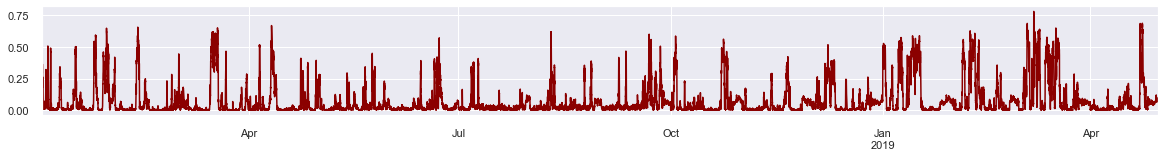

In [6]:
print()
print('timeframe BEGINS on:', df.index.min()) 
print('timeframe ENDS on:', df.index.max()) 

###### PLOT #######
plot = df.target_losses_norm.plot(figsize=(20,2), color='darkred');
plt.savefig('figures/overview_target.png', bbox_inches='tight', transparent=True)
plt.show();

In [16]:
def plot_target_interactive(og_ts, start_date=None, end_date=None, og_ts_opacity = 1):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = og_ts.index, y = np.array(og_ts.values), name = "Observed",
                         line_color = 'darkred', opacity = og_ts_opacity))
    fig.update_layout(title_text = 'Target Data Full View', 
                  xaxis_rangeslider_visible = True, )
    fig.update_xaxes(type="date", range=[start_date, end_date])
    fig.show()
    
if True: 
    plot_target_interactive(df.target_losses_norm)

In addition to the target data (endogenous variable), the above loaded Data Frame contains various meteorological parameters obtained from a numerical weather model (GFS data, e.g., `t_100m_k`) and categorical data (e.g., `summer`)  that can be used for predictions (exogenous variables). In the following graphs example Exogenous Features are shown in their variation over time. 

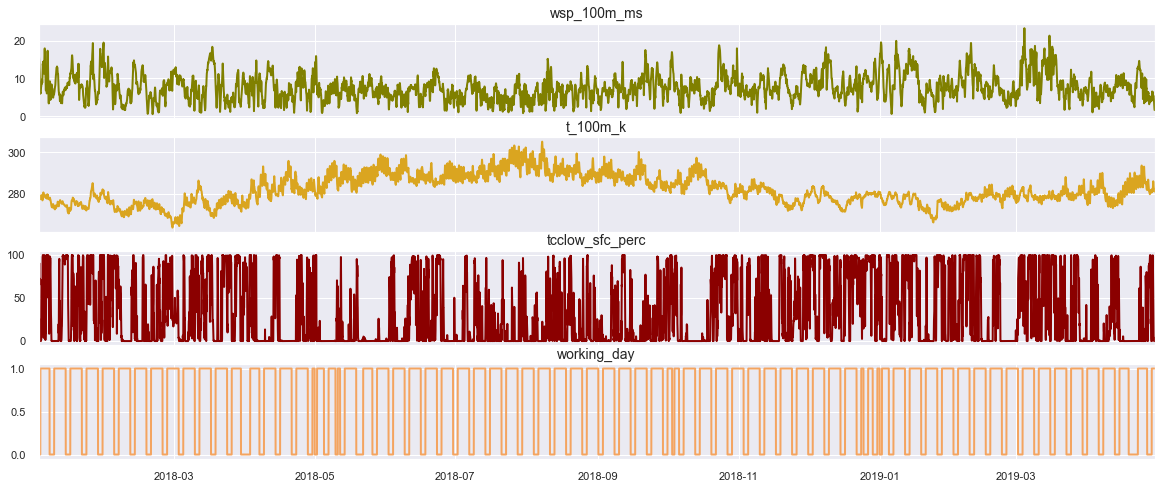

In [30]:
#### DATA SELECTION ####

f_to_plot = ['wsp_100m_ms', 't_100m_k','tcclow_sfc_perc', 'working_day']

#### PLOTTING #####
color=iter(['olive', 'goldenrod', 'darkred', 'sandybrown', 'sienna', 'grey'])
fig, axs = plt.subplots(len(f_to_plot), sharex=True, figsize=(20,len(f_to_plot)*2), facecolor='w')
for f, axes in zip(f_to_plot, axs): 
    c=next(color )
    axes.plot(df[f], color=c, lw=2)
    axes.set_title(f, fontsize=14)
    axes.set_xlim(left=df[f].index[0], right=df[f].index[-1])
###### OUTPUT #######
fig.savefig('figures/overview_GFS.png', bbox_inches='tight', transparent=True)
fig.show();

In [19]:
if False: 
    df.iloc[:, np.r_[0:16, 22]].plot(subplots=True, color='darkred', figsize=(20, 20), layout=(8,2), legend=True, );
    [ax.legend(loc=2) for ax in plt.gcf().axes];

## Continuity Check

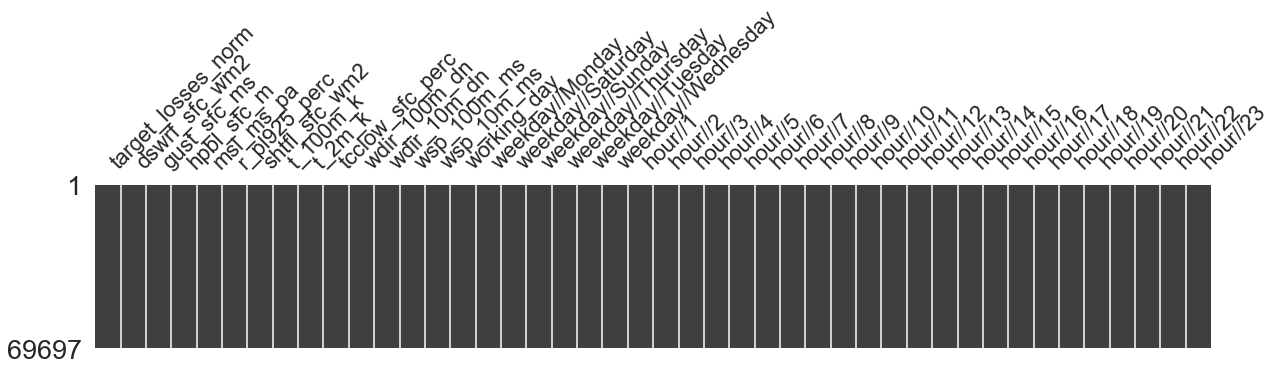

In [32]:
msno.matrix(df, figsize=(20, 3), sparkline=False, fontsize=22);

## Data Splitting 

### Global Variable (Starting points of days to test models on)

In [33]:
timeframes = ['2018-07-08 00:00', '2018-08-10 00:00', '2018-09-21 00:00','2018-10-11 00:00','2018-11-20 00:00', 
              '2018-12-25 00:00', '2019-01-11 00:00','2019-02-11 00:00','2019-03-20 00:00','2019-04-01 00:00']

In [34]:
#### FUNCTION DESIGN ####
def select_random_timestamps(df=df, start_ts='2019-01-01 00:00', end_ts='2019-04-19 00:00', num=2): 
    index_elements = list(df.loc[start_ts:end_ts].index)
    random.seed(RSEED)
    selected = random.choices(index_elements, k=num)
    selected = [dateTimeObj.strftime('%Y-%m-%d %H:%M') for dateTimeObj in selected]
    return selected

#### FUNCTION CALL ####
start_ts='2019-01-01 00:00' 
end_ts='2019-04-19 00:00'
num_val_timesteps = 1440 
val_timestamps = select_random_timestamps(num=num_val_timesteps, start_ts=start_ts, end_ts=end_ts)
print('First 3 Timestamps:')
print(val_timestamps[0:3])
print()

#STATS OUPTUT
print('Number of possible timesteps:', len(df.loc[start_ts:end_ts].index))
print('Selected timesteps:', num_val_timesteps)
print('Selected in percent of optional timesteps: ', round(num_val_timesteps / len(df.loc[start_ts:end_ts].index),2)*100)

First 3 Timestamps:
['2019-03-11 01:30', '2019-01-03 16:40', '2019-01-30 16:50']

Number of possible timesteps: 15553
Selected timesteps: 1440
Selected in percent of optional timesteps:  9.0


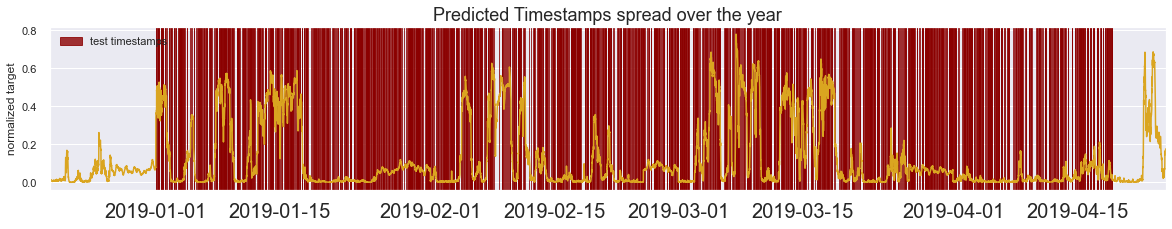

In [35]:
#### PLOTTING #####
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(df.target_losses_norm, color = 'goldenrod')
i = 0 #used to have the label of the test_timestamp only ones. 
for ts in val_timestamps:
    start = date2num(pd.to_datetime(ts)) 
    stop = date2num(pd.to_datetime(ts)+pd.DateOffset(minute=1)) 
    ax.axvspan(start, stop, color="darkred", alpha=0.8, label="_"*i + "test timestamps")
    ax.legend(loc='upper left')
    i += 1 #labels starting with "_" are not shown. 

#### PLOT LABELS #####
left_xlim = pd.Timestamp('2018-12-20 00:00:00')
right_xlim = pd.Timestamp('2019-04-25 00:00:00')
ax.set_ylabel('normalized target')
ax.tick_params(axis="x", labelsize=20)
ax.set_title('Predicted Timestamps spread over the year', size=18)
ax.set_xlim(left=left_xlim, right=right_xlim)


##### OUTPUT ######
fig.savefig('figures/predicted_timestamps.png', bbox_inches='tight', transparent=True)
fig.show();

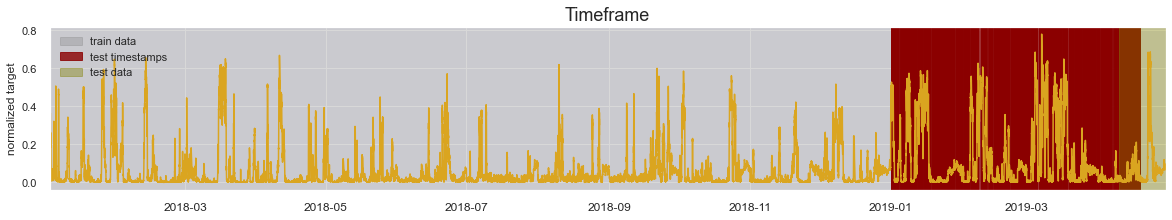

In [36]:
#### PLOTTING #####
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(df.target_losses_norm, color = 'goldenrod')

###train_timeframe 
start_train = pd.Timestamp('2018-01-01 00:00:00')
end_train = pd.Timestamp('2019-01-01 00:00:00')
start = date2num(pd.to_datetime(start_train)) 
stop = date2num(pd.to_datetime(end_train))
ax.axvspan(start, stop, color="grey", alpha=0.3, label="train data")

i = 0 #used to have the label of the test_timestamp only ones. 
for ts in val_timestamps:
    start = date2num(pd.to_datetime(ts)) 
    stop = date2num(pd.to_datetime(ts)+pd.DateOffset(minute=1)) 
    ax.axvspan(start, stop, color="darkred", alpha=0.8, label="_"*i + "test timestamps")
    ax.legend(loc='upper left')
    i += 1 #labels starting with "_" are not shown. 


###train_timeframe 
start_train = pd.Timestamp('2019-04-10 00:00:00')
end_train = pd.Timestamp('2019-04-30 06:00:00')
start = date2num(pd.to_datetime(start_train)) 
stop = date2num(pd.to_datetime(end_train))
ax.axvspan(start, stop, color="olive", alpha=0.4, label="test data")



#### PLOT LABELS #####
ax.legend(loc='upper left')
ax.set_ylabel('normalized target')
ax.tick_params(axis="x", labelsize=12)
ax.set_title('Timeframe', size=18)
ax.set_xlim(left=df.index.min(), right=df.index.max())

##### OUTPUT ######
fig.savefig('figures/train_timeframe.png', bbox_inches='tight', transparent=True)
fig.show();

# Modeling

## General Functions

### Error Metrics Function (RMSE, R2, MAE, MAPE)

In [37]:
def error_metrics(y_pred, y_truth, model_name = "default"):
    """
    Calculate error metrics for a single comparison between predicted and observed values
    or the mean error metrics of multiple comparisons (inputs should be lists)
    """
    
    #checking if the inputs are lists or single arrays
    if isinstance(y_pred, list) and isinstance(y_truth, list):
        
        # creating empty arrays for the error metrics of the different splits
        RMSE = []
        R2 = []
        MAE = []
        MAPE = []
        
        # calculating and appending the error metrics for the different splits
        for i in range(len(y_pred)):
            RMSE.append(np.sqrt(mean_squared_error(y_truth[i], y_pred[i])))
            R2.append(r2_score(y_truth[i], y_pred[i]))
            MAE.append(mean_absolute_error(y_truth[i], y_pred[i]))
            MAPE.append((np.mean(np.abs((y_truth[i] - y_pred[i]) / y_truth[i])) * 100))
        
        # calculating the means of the error metrics
        RMSE_return = np.mean(RMSE)
        R2_return = np.mean(R2)
        MAE_return = np.mean(MAE)
        MAPE_return = np.mean(MAPE)
    
    # if inputs are single arrays
    else:
        
        # calculating error metrics
        RMSE_return = np.sqrt(mean_squared_error(y_truth, y_pred))
        R2_return = r2_score(y_truth, y_pred)
        MAE_return = mean_absolute_error(y_truth, y_pred)
        MAPE_return = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)
    
    # printing error metrics
    print('\nError metrics for {}'.format(model_name))
    print("RMSE or Root mean squared error: %.2f" % RMSE_return)
    print('R2-Score: %.2f' % R2_return )
    print('Mean Absolute Error: %.2f' % MAE_return)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE_return)
    
    # saving error metrics in a dataframe and returning it
    name_error = ['RMSE', 'R2', 'MAE', 'MAPE']
    value_error = [RMSE_return, R2_return, MAE_return, MAPE_return/100]
    dict_error = dict()
    for i in range(len(name_error)):
        dict_error[name_error[i]] = [value_error[i]]
    errors = pd.DataFrame(dict_error).T
    errors.rename(columns={0 : model_name}, inplace = True)
    
    #path = './data/error_metrics_{}.pkl'.format(model_name)
    #errors.to_pickle(path)
        
    return(errors)

### Residual plot (prediction vs observation)

In [38]:
def plot_predvstrue_reg(pred, truth, model_name=None):
    """
    Plots the observed target_loss values against the predicted target_loss values
    """
    fig, ax = plt.subplots(1,1, figsize=(20,6))
    ax.scatter(truth, pred) 
    _ = plt.xlabel("Observed target_loss")
    _ = plt.ylabel("Predicted target_loss")
    _ = plt.title("Observed vs Predicted target_loss using model {}".format(model_name))
    _ = plt.xlim(1000, 5000)
    _ = plt.ylim(1000, 5000)
    #plotting 45 deg line to see how the prediction differs from the observed values
    x = np.linspace(*ax.get_xlim())
    _ = ax.plot(x, x)

### Plotting the true time series and the predicted time series in plotly interactive plot

In [39]:
def plot_ts_pred(og_ts, pred_ts, model_name=None, start_date=None, end_date=None, og_ts_opacity = 0.5, pred_ts_opacity = 0.5):
    """
    Plot plotly time series of the original (og_ts) and predicted (pred_ts) time series values to check how our model performs.
    model_name: name of the model used for predictions
    og_ts_opacity: opacity of the original time series
    pred_ts_opacity: opacity of the predicted time series
    """
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = og_ts.index, y = np.array(og_ts.values), name = "Observed",
                         line_color = 'deepskyblue', opacity = og_ts_opacity))

    try:
        fig.add_trace(go.Scatter(x = pred_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))
    except: #if predicted values are a numpy array they won't have an index
        fig.add_trace(go.Scatter(x = og_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))


    #fig.add_trace(go)
    fig.update_layout(title_text = 'Observed target_loss vs predicted target_loss values using {}'.format(model_name),
                  xaxis_rangeslider_visible = True, )
    
    fig.update_xaxes(type="date", range=[start_date, end_date])
    fig.show()

### Train-Test split that respects temporal order of observations

In [40]:
def train_test(data, test_size = 0.2, ignore_X = False):
    """
        Perform train-test split with respect to time series structure
        - df: dataframe with variables X_n to train on and the dependent output y which is the column 'target_losses_norm' in this notebook
        - test_size: size of test set 
    """
    df = data.copy()
    
    # get the index after which test set starts
    test_index = int(len(df)*(1-test_size))
    
    # printing the sizes of the whole dataset, the training set and the test set
    print('Observations: %d' % (len(df)))
    print('Training Observations: %d' % (test_index))
    print('Testing Observations: %d' % (len(df)-test_index))
    
    if ignore_X:
        # collecting the training and test data based on the calculated test_index (only the y-values)
        y_train = df.target_losses_norm.iloc[:test_index]
        y_test = df.target_losses_norm.iloc[test_index:]
        return y_train, y_test
    else:
        # collecting the training and test data based on the calculated test_index
        X_train = df.drop('target_losses_norm', axis = 1).iloc[:test_index]
        y_train = df.target_losses_norm.iloc[:test_index]
        X_test = df.drop('target_losses_norm', axis = 1).iloc[test_index:]
        y_test = df.target_losses_norm.iloc[test_index:]
        return X_train, X_test, y_train, y_test
    

### Multiple Train-Test splits that respect temporal order of observations

In [41]:
def mul_train_test(data, n_splits=3):
    """
        Perform multiple train-test splits with respect to time series structure
        - df: dataframe with variables X_n to train on and the dependent output y which is the column 'target_losses_norm' in this notebook
        - n_splits: number of splits  
    """
    #creating copy of input data
    df = data.copy()
    
    #initializing TimeSeriesSplit with chosen number of splits
    splits = TimeSeriesSplit(n_splits)
    
    #separating label from features
    X = df.drop('target_losses_norm', axis = 1)
    y = df.target_losses_norm
    
    #initializing empty lists for X_train, X_test, y_train and y_test
    mul_X_train = []
    mul_X_test = []
    mul_y_train = []
    mul_y_test = []

    #creating multiple splits and storing the train and test sets in lists while also printing the corresponding sizes
    #of the whole set, the training set and the test set for each split
    for train_index, test_index in splits.split(df):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        print('Observations: %d' % (len(df)))
        print('Training Observations: %d' % (len(X_train)))
        print('Testing Observations: %d' % (len(X_test)))
        mul_X_train.append(X_train)
        mul_y_train.append(y_train)
        mul_X_test.append(X_test)
        mul_y_test.append(y_test)
    
    return mul_X_train, mul_X_test, mul_y_train, mul_y_test



## Naive Base Model

First a naive base model is implemented. This model always predicts the last seen value as the next.

In [42]:
naive = df["target_losses_norm"].to_frame().copy(deep= True)
naive["predicted"] = naive["target_losses_norm"].shift(1)
naive = naive.dropna()
naive.columns = ['y_test', 'y_pred']
naive.head(2)

y_test    y_pred
2018-01-01 06:10:00  0.404513  0.425598
2018-01-01 06:20:00  0.405137  0.404513

In [43]:
# setting up a dataframe for the results
naive_results = pd.DataFrame(columns = ["y_test", "y_pred"])

for tfstart in timeframes:
    tfend = pd.to_datetime(tfstart) + pd.Timedelta(hours=24)
    naive_results = naive_results.append(naive[(naive.index >= tfstart) & (naive.index <= tfend)])
    
    # plotting the predicted values and the true values
    plot_ts_pred(naive[(naive.index >= tfstart) & (naive.index <= tfend)]["y_test"], 
                 naive[(naive.index >= tfstart) & (naive.index <= tfend)]["y_pred"], 
                 #start_date=timeframes[0], 
                 #end_date=pd.to_datetime(timeframes[0]) + pd.Timedelta(hours=24), 
                 model_name="Naive Base Model", 
                 og_ts_opacity = 0.8, 
                 pred_ts_opacity = 0.8)

In [44]:
# evaluating the naive base model for the test data and saving metrics in dictionary for later use
error_metrics_naive_base_model = error_metrics(naive_results["y_pred"], naive_results["y_test"], "Naive Base Model")
error_metrics_naive_base_model


Error metrics for Naive Base Model
RMSE or Root mean squared error: 0.02
R2-Score: 0.99
Mean Absolute Error: 0.01
Mean Absolute Percentage Error: 11.19 %


Naive Base Model
RMSE          0.017165
R2            0.987427
MAE           0.008938
MAPE          0.111866

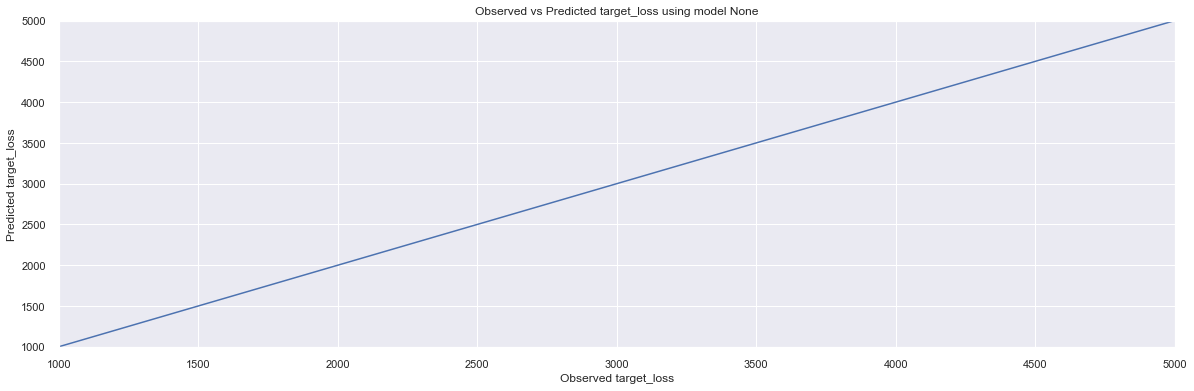

In [45]:
# plotting the predicted values against the true values
plot_predvstrue_reg(naive_results["y_pred"],naive_results["y_test"]);

## Exponential Smoothing

In [46]:
span = 3 #averaging over the last 30 minutes
ExpoSmoo = df[["target_losses_norm"]].copy(deep= True)
# Applying the  exponential weighted (EW) functions and then the mean
ExpoSmoo["y_pred"] = ExpoSmoo.rolling(window=span, min_periods=span).mean()
ExpoSmoo = ExpoSmoo.dropna()
ExpoSmoo.columns = ['y_test', 'y_pred']
ExpoSmoo.head(2)

y_test    y_pred
2018-01-01 06:20:00  0.405137  0.411750
2018-01-01 06:30:00  0.481961  0.430537

In [47]:
ExpoSmoo_results = pd.DataFrame(columns = ["y_test", "y_pred"])

for tfstart in timeframes:
    tfend = pd.to_datetime(tfstart) + pd.Timedelta(hours=24)
    ExpoSmoo_results = ExpoSmoo_results.append(ExpoSmoo[(ExpoSmoo.index >= tfstart) & (ExpoSmoo.index <= tfend)])
    # plotting the predicted values and the true values
    plot_ts_pred(ExpoSmoo[(ExpoSmoo.index >= tfstart) & (ExpoSmoo.index <= tfend)]["y_test"], 
                 ExpoSmoo[(ExpoSmoo.index >= tfstart) & (ExpoSmoo.index <= tfend)]["y_pred"], 
                 #start_date=timeframes[0], 
                 #end_date=pd.to_datetime(timeframes[0]) + pd.Timedelta(hours=24), 
                 model_name="Exponential Smoothing Model", 
                 og_ts_opacity = 0.8, 
                 pred_ts_opacity = 0.8)

In [48]:
error_metrics_ExpoSmoo_model = error_metrics(ExpoSmoo_results["y_pred"], ExpoSmoo_results["y_test"], "Exponential Smoothing")
error_metrics_ExpoSmoo_model


Error metrics for Exponential Smoothing
RMSE or Root mean squared error: 0.01
R2-Score: 0.99
Mean Absolute Error: 0.01
Mean Absolute Percentage Error: 9.13 %


Exponential Smoothing
RMSE               0.014404
R2                 0.991147
MAE                0.007483
MAPE               0.091309

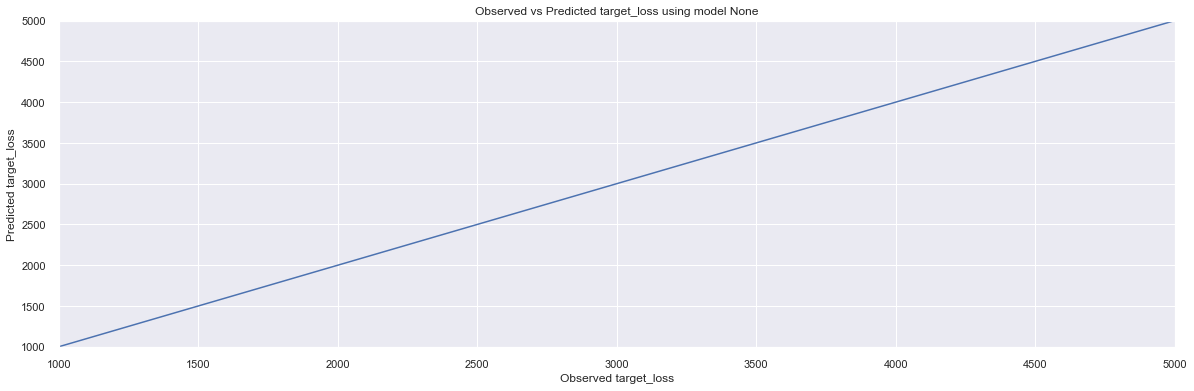

In [49]:
plot_predvstrue_reg(ExpoSmoo_results["y_pred"],ExpoSmoo_results["y_test"])

## Dicky Fuller Test (Stationarity)

- **Null Hypothesis (H0):** If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- **Alternate Hypothesis (H1):** The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [50]:
# function to save and print the results of a Dicky Fuller Test
def run_adfuller(ts):
    result = adfuller(ts, autolag='AIC')
    # Print test statistic
    print("t-stat", result[0])
    # Print p-value
    print("p-value", result[1])
    # Print #lags used
    print("#lags used", result[2])
    # Print critical values
    print("critical values", result[4])

In [51]:
run_adfuller(df['target_losses_norm'])

t-stat -13.79947998448172
p-value 8.624940928111837e-26
#lags used 62
critical values {'1%': -3.430443913046454, '5%': -2.861581507895739, '10%': -2.5667920932351938}


We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

**Observations**: 
- The null hypothesis of our data being non-stationary can be rejected.

## Autocorrelation and Partial Autocorrelation

In [52]:
def acf_pacf_plots(ts, lags, figsize = (12,8)):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = figsize)
    # Plot the ACF of ts for the first "lags" number of lags
    _ = plot_acf(ts, lags = lags, zero = False, ax = ax1, alpha = 0.05)
    # Plot the PACF of ts for the first "lags" number of lags
    _ = plot_pacf(ts, lags = lags, zero = False, ax = ax2, alpha = 0.05)

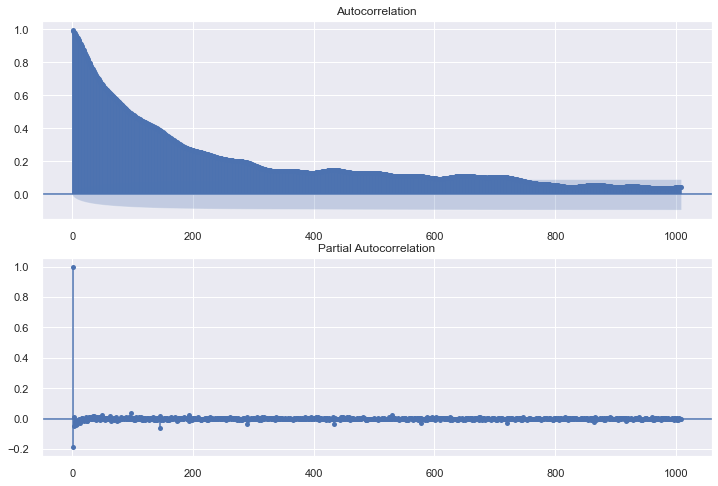

In [53]:
# Create the acf and pacf plots for one week worth of lags
acf_pacf_plots(df['target_losses_norm'], lags = 7*24*6, figsize = (12,8))

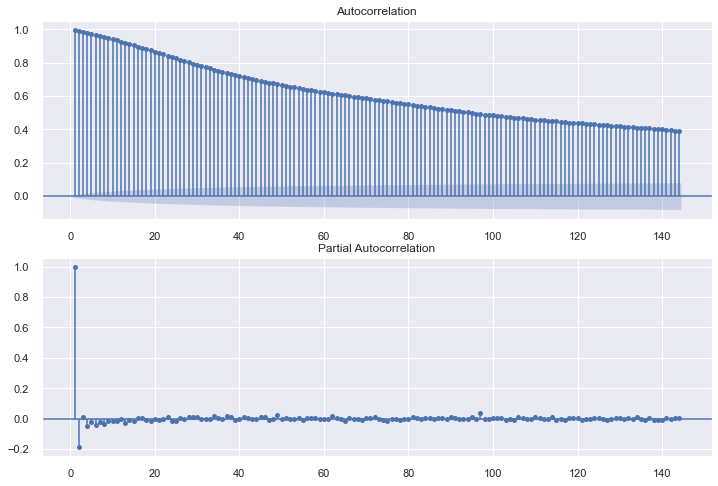

In [54]:
# Create the acf and pacf plots for one day worth of lags
acf_pacf_plots(df['target_losses_norm'], lags = 24*6, figsize = (12,8))

**Observation:** Since the autocorrelation coeffiencts are steadily decreasing for every further lag that is considered, we can confirm the result from the Dicky Fuller Test, that the data does not contain any seasonality. But to make it more stationary differencing is needed.

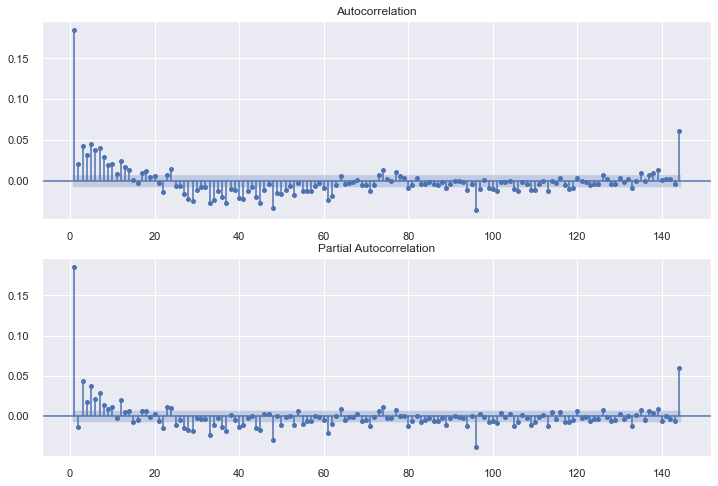

In [55]:
differenced_1 = df['target_losses_norm'].diff(1).dropna()

# Create the acf and pacf plots for one day worth of lags for the differenced series
acf_pacf_plots(differenced_1, lags = 24*6, figsize = (12,8))

### Finding optimal ARIMA parameters with auto_arima

In [56]:
run = False 
if run: 
    model = pm.auto_arima(differenced_1, start_p=0, start_q=0,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=3, max_q=5, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          start_P=0, 
                          D=0, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

    print(model.summary())

The optimal parameters seem to be (1,1,3), because the series was differenced once before using auto_arima.

## ARIMA Model

In [57]:
def rolling_arima_model(series, tfstart, arima_order):
    """
        Predict values for one day (rolling-forward training window: 180 days)
        - series: target variable that should be predicted
        - tfstart: timestamps of the day to predict for
        - arima_order: order of the ARIMA model
    """
    window_size = 180*24*6
    tfend = pd.to_datetime(tfstart) + pd.Timedelta(hours=24)
    y_test = series[(series.index >= tfstart) & (series.index <= tfend)]
    y_train = series[(series.index < tfstart)]
    train_start_index = len(y_train)-window_size-1
    y_train = y_train.iloc[train_start_index::]
    
    y_train_list, y_test_list = y_train.values.tolist(), y_test.values.tolist()
    history = [x for x in y_train_list]
    predictions = list()
    
    for t in tqdm(range(len(y_test_list))):
        model = ARIMA(y_train_list, order=arima_order)
        model_fit = model.fit(disp=0)
        predictions.append(model_fit.forecast()[0])
        y_train_list.pop(0)
        y_train_list.append(y_test_list.pop(0)) 
    
    y_pred = pd.Series(v[0] for v in predictions)
    y_pred.index = y_test.index
    y_pred.name = "y_pred"
    
    return y_pred, y_test

In [58]:
def arima_predict(series, list_start_dates, arima_order):
    """
        Predict values for multiple different days (rolling-forward training window: 180 days)
        - series: target variable that should be predicted
        - list_start_dates: timestamps of the days to predict for
        - arima_order: order of the ARIMA model
    """
    
    #setting up the dataframe to store all the actual and predicted values in
    df_arima = pd.DataFrame(columns = ["y_pred","y_test"])
    
    #iterating over the given start dates
    for start_date in tqdm(list_start_dates):
        
        #calculating the predictions with the rolling-forward-window arima model
        y_pred, y_test = rolling_arima_model(series, tfstart = start_date, arima_order = arima_order)
        
        #saving and appending the acutal and predicted values to storage dataframe
        memorydf = pd.DataFrame(columns = ["y_pred","y_test"])
        memorydf = pd.DataFrame(columns = ["y_pred","y_test"])
        memorydf["y_pred"] = y_pred
        memorydf["y_test"] = y_test
        df_arima = df_arima.append(memorydf)
        
    #saving the results to csv
    df_arima.to_csv('results_arima{}{}{}.csv'.format(arima_order[0],arima_order[1],arima_order[2]))
    
    #returning the result dataframe
    return df_arima

### TJ rechnet

In [59]:
#results_first_5 = arima_predict(df["target_losses_norm"], timeframes[0:5], (1,1,3))

### JJ rechnet

In [60]:
#results_second_5 = arima_predict(df["target_losses_norm"], timeframes[5::], (1,1,3))

## Comparing Models

In [61]:
model_errors = []
model_errors.append(error_metrics_naive_base_model)
model_errors.append(error_metrics_ExpoSmoo_model)
#model_errors.append(errors_arima000)


df_errors = pd.concat(model_errors, axis = 1)
df_errors

Naive Base Model  Exponential Smoothing
RMSE          0.017165               0.014404
R2            0.987427               0.991147
MAE           0.008938               0.007483
MAPE          0.111866               0.091309